![enter image description here][1]

Predicting who said it: Trump or Clinton
========================================

**By: Ignacio Chavarria ([@ignacio_chr][2])**

In this notebook, I use tf-idf scores and a Naive Bayes classifier to predict whether a tweet is more likely to have been tweeted by @realDonaldTrump or @HillaryClinton.

Ever wonder which candidate you tweet like? Follow these steps to find out:

 1. Fork this notebook
 2. Replace the text string portion of the last cell with a personal tweet
 3. Run the notebook!

Test accuracy score: 93.66%

Credits: 

 - Spam filter (used in section 2): http://radimrehurek.com/data_science_python/ 

 - Cover photo: http://www.wsj.com


  [1]: http://si.wsj.net/public/resources/images/OG-AH736_Twitte_G_20160718163322.jpg
  [2]: http://www.twitter.com/ignacio_chr
  [3]: http://twitter.com/realDonaldTrump
  [4]: http://twitter.com/HillaryClinton

----------

1. Data exploration and analysis
=============================================================

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Series
import seaborn as sns
import calendar
import datetime
import re

In [2]:
df1 = pd.read_csv('../input/tweets.csv', encoding="utf-8")
df1 = df1[['handle','text','is_retweet']]

df = df1.loc[df1['is_retweet'] == False]
df = df.copy().reset_index(drop=True)

Extract mentions from tweets
------------------------------------------------------------------------

In [3]:
def all_mentions(tw):
    test2 = re.findall('(\@[A-Za-z_]+)', tw)
    if test2:
        return test2
    else:
        return ""

df['top_mentions'] = df['text'].apply(lambda x: all_mentions(x))

mention_list_trump = []
mention_list_clinton = []
for n in range(len(df['top_mentions'])):
    if df['handle'][n] == 'realDonaldTrump':
        mention_list_trump += df['top_mentions'][n]
    elif df['handle'][n] == 'HillaryClinton':
        mention_list_clinton += df['top_mentions'][n]

Graph mentions most used by candidates (top 10)
---------------------------------------

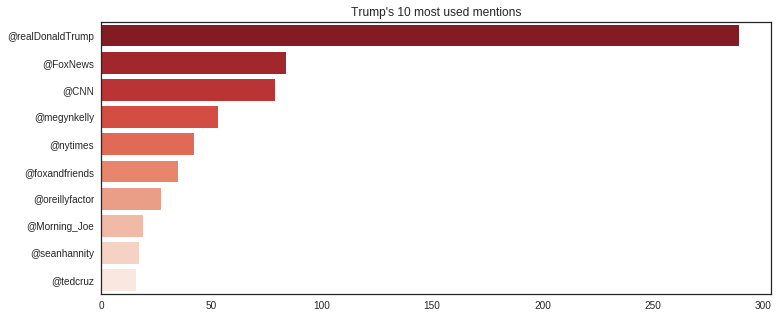

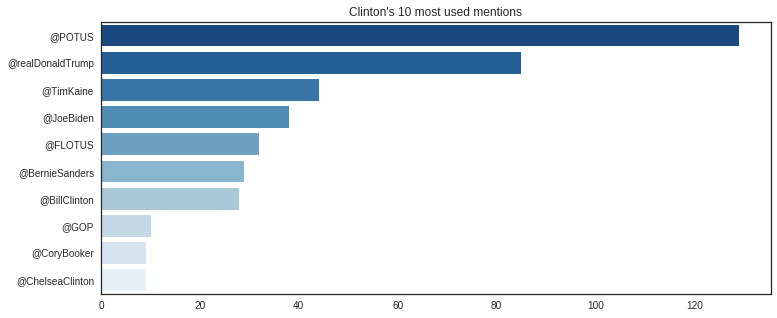

In [4]:
data1 = Series(mention_list_trump).value_counts().head(n=10)
sns.set_style("white")
plt.figure(figsize=(12, 5))
sns.barplot(x=data1, y=data1.index, orient='h', palette="Reds_r").set_title("Trump's 10 most used mentions")

data2 = Series(mention_list_clinton).value_counts().head(n=10)
sns.set_style("white")
plt.figure(figsize=(12, 5))
sns.barplot(x=data2, y=data2.index, orient='h', palette="Blues_r").set_title("Clinton's 10 most used mentions")

**Seems like one thing both candidates had in common was their frequent mention of Trump. Surprinsingly, while Trump was Hillary's 2nd most mentioned account, she was not on Trump's list.**

Extract hashtags from tweets
----------------------------

In [5]:
def get_hashtags(tw):
    test3 = re.findall('(\#[A-Za-z_]+)', tw)
    if test3:
        return test3
    else:
        return ""

df['top_hashtags'] = df['text'].apply(lambda x: get_hashtags(x))

hashtags_list_trump = []
hashtags_list_clinton = []
for n in range(len(df['top_hashtags'])):
    if df['handle'][n] == 'realDonaldTrump':
        hashtags_list_trump += df['top_hashtags'][n]
    elif df['handle'][n] == 'HillaryClinton':
        hashtags_list_clinton += df['top_hashtags'][n]

Graph hashtags most used by candidates (top 10)
---------------------------------------

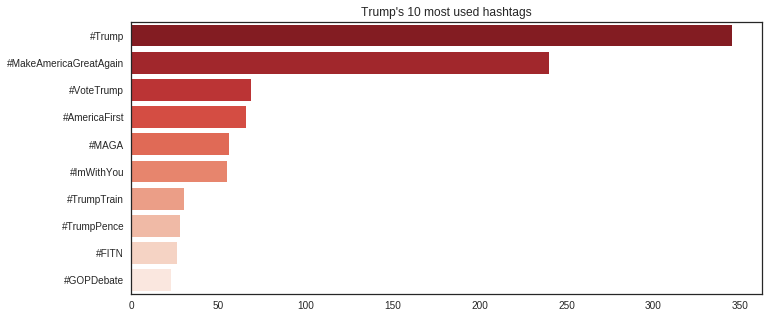

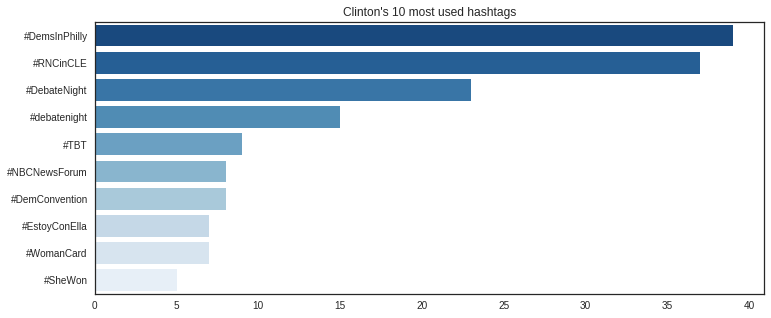

In [6]:
data3 = Series(hashtags_list_trump).value_counts().head(n=10)
sns.set_style("white")
plt.figure(figsize=(11.3, 5))
sns.barplot(x=data3, y=data3.index, orient='h', palette="Reds_r").set_title("Trump's 10 most used hashtags")

data4 = Series(hashtags_list_clinton).value_counts().head(n=10)
sns.set_style("white")
plt.figure(figsize=(12, 5))
sns.barplot(x=data4, y=data4.index, orient='h', palette="Blues_r").set_title("Clinton's 10 most used hashtags")

**It seems Trump was much more fond of hashtags than Hillary, using his favorite hashtag (#Trump) almost 9x more than she used her favorite (#DemsInPhilly).**

In [7]:
df['length_no_url'] = df['text']
df['length_no_url'] = df['length_no_url'].apply(lambda x: len(x.lower().split('http')[0]))
df['message'] = df['text'].apply(lambda x: x.lower().split('http')[0])

def candidate_code(x):
    if x == 'HillaryClinton':
        return 'Hillary'
    elif x == 'realDonaldTrump':
        return 'Trump'
    else:
        return ''

df['label'] = df['handle'].apply(lambda x: candidate_code(x))

----------

2. Training/testing model
==============================================

In [8]:
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import StratifiedKFold, cross_val_score, train_test_split 
from sklearn.tree import DecisionTreeClassifier 

/opt/conda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Create new dataframe for prediction model with ***candidate name*** (as **label**) and ***tweets*** (as **message**):

In [9]:
messages = df[['label','message']]

In [10]:
print(messages[:5])

     label                                            message
0  Hillary  the question in this election: who can put the...
1  Hillary  if we stand together, there's nothing we can't...
2  Hillary  both candidates were asked about how they'd co...
3    Trump  join me for a 3pm rally - tomorrow at the mid-...
4  Hillary  this election is too important to sit out. go to 


In [11]:
def split_into_tokens(message):
    message = message  # convert bytes into proper unicode
    return TextBlob(message).words

In [12]:
messages.message.head()

0    the question in this election: who can put the...
1    if we stand together, there's nothing we can't...
2    both candidates were asked about how they'd co...
3    join me for a 3pm rally - tomorrow at the mid-...
4    this election is too important to sit out. go to 
Name: message, dtype: object

In [13]:
messages.message.head().apply(split_into_tokens)

0    [the, question, in, this, election, who, can, ...
1    [if, we, stand, together, there, 's, nothing, ...
2    [both, candidates, were, asked, about, how, th...
3    [join, me, for, a, 3pm, rally, tomorrow, at, t...
4    [this, election, is, too, important, to, sit, ...
Name: message, dtype: object

In [14]:
def split_into_lemmas(message):
    message = message.lower()
    words = TextBlob(message).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

messages.message.head().apply(split_into_lemmas)

0    [the, question, in, this, election, who, can, ...
1    [if, we, stand, together, there, 's, nothing, ...
2    [both, candidate, were, asked, about, how, the...
3    [join, me, for, a, 3pm, rally, tomorrow, at, t...
4    [this, election, is, too, important, to, sit, ...
Name: message, dtype: object

In [15]:
bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(messages['message'])
print(len(bow_transformer.vocabulary_))
print(bow_transformer.get_feature_names()[:5])

9016
["'16", "'84", "'a", "'american", "'amnesty"]


In [16]:
messages_bow = bow_transformer.transform(messages['message'])
print('sparse matrix shape:', messages_bow.shape)
print('number of non-zeros:', messages_bow.nnz)
print('sparsity: %.2f%%' % (100.0 * messages_bow.nnz / (messages_bow.shape[0] * messages_bow.shape[1])))

sparse matrix shape: (5722, 9016)
number of non-zeros: 91236
sparsity: 0.18%


In [17]:
tfidf_transformer = TfidfTransformer().fit(messages_bow)

In [18]:
print (tfidf_transformer.idf_[bow_transformer.vocabulary_['the']])
print (tfidf_transformer.idf_[bow_transformer.vocabulary_['hannity']])

1.886255343
7.86048895318


In [19]:
messages_tfidf = tfidf_transformer.transform(messages_bow)
print(messages_tfidf.shape)

(5722, 9016)


In [20]:
%time spam_detector = MultinomialNB().fit(messages_tfidf, messages['label'])

CPU times: user 16 ms, sys: 4 ms, total: 20 ms
Wall time: 19.7 ms


In [21]:
all_predictions = spam_detector.predict(messages_tfidf)

In [22]:
tr_acc = accuracy_score(messages['label'], all_predictions)
print("Accuracy on training set:  %.2f%%" % (100 * tr_acc))

Accuracy on training set:  97.10%


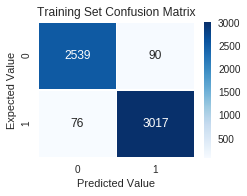

In [23]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(messages['label'], all_predictions), annot=True, linewidths=.5, ax=ax, cmap="Blues", fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
sns.plt.title('Training Set Confusion Matrix')

In [24]:
print(classification_report(messages['label'], all_predictions))

             precision    recall  f1-score   support

    Hillary       0.97      0.97      0.97      2629
      Trump       0.97      0.98      0.97      3093

avg / total       0.97      0.97      0.97      5722



In [25]:
msg_train, msg_test, label_train, label_test = \
    train_test_split(messages['message'], messages['label'], test_size=0.2, random_state=1)

print(len(msg_train), len(msg_test), len(msg_train) + len(msg_test))

4577 1145 5722


In [26]:
pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=split_into_lemmas)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [27]:
scores = cross_val_score(pipeline,  # steps to convert raw messages into models
                         msg_train,  # training data
                         label_train,  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
print(scores)

[ 0.93464052  0.92156863  0.9279476   0.94104803  0.94323144  0.95404814
  0.95623632  0.9321663   0.92997812  0.9321663 ]


In [28]:
print('Mean score:', scores.mean(), '\n')
print('Stdev:', scores.std())

Mean score: 0.937303141056 

Stdev: 0.0106613798352


In [29]:
params = {
    'tfidf__use_idf': (True, False),
    'bow__analyzer': (split_into_lemmas, split_into_tokens),
}

grid = GridSearchCV(
    pipeline,  # pipeline from above
    params,  # parameters to tune via cross validation
    refit=True,  # fit using all available data at the end, on the best found param combination
    n_jobs=-1,  # number of cores to use for parallelization; -1 for "all cores"
    scoring='accuracy',  # what score are we optimizing?
    cv=StratifiedKFold(label_train, n_folds=5),  # what type of cross validation to use
)

%time nb_detector = grid.fit(msg_train, label_train)
print(nb_detector.grid_scores_)

CPU times: user 3.36 s, sys: 148 ms, total: 3.51 s
Wall time: 34 s
[mean: 0.93664, std: 0.00795, params: {'bow__analyzer': <function split_into_lemmas at 0x7f3da2ecd2f0>, 'tfidf__use_idf': True}, mean: 0.92593, std: 0.00857, params: {'bow__analyzer': <function split_into_lemmas at 0x7f3da2ecd2f0>, 'tfidf__use_idf': False}, mean: 0.93445, std: 0.00690, params: {'bow__analyzer': <function split_into_tokens at 0x7f3da37c5510>, 'tfidf__use_idf': True}, mean: 0.92528, std: 0.00669, params: {'bow__analyzer': <function split_into_tokens at 0x7f3da37c5510>, 'tfidf__use_idf': False}]


In [30]:
predictions = nb_detector.predict(msg_test)
print(classification_report(label_test, predictions))

             precision    recall  f1-score   support

    Hillary       0.92      0.92      0.92       517
      Trump       0.94      0.93      0.93       628

avg / total       0.93      0.93      0.93      1145



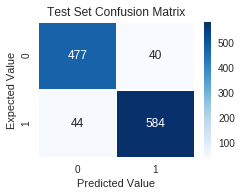

In [31]:
fig, ax = plt.subplots(figsize=(3.5,2.5))
sns.heatmap(confusion_matrix(label_test, predictions), annot=True, linewidths=.5, ax=ax, cmap="Blues", fmt="d").set(xlabel='Predicted Value', ylabel='Expected Value')
sns.plt.title('Test Set Confusion Matrix')

In [32]:
print("Accuracy on test set:  %.2f%%" % (100 * (nb_detector.grid_scores_[0][1])))

Accuracy on test set:  93.66%


----------

3. Finding the most representative terms for each candidate
============================================================

This model cares more about **how rare a term is**, not just frequency. 

Many terms used by a candidate will also be used by his/her rival, not giving much insight into the tweet's author. For example, the term "and" is used frequently in the dataset, but passing it through the model will result in a prediction probability of about 50/50 (not helpful at all); however, there are **terms that are used much less frequently, but almost exclusively by certain candidates.**  Those are the words (or groups of words) this model looks for in order to make an accurate prediction.

Extract terms with highest tf-idf scores
-------------------------------------------------------------

In [33]:
top_h = {}
top_t = {}

for w in (bow_transformer.get_feature_names()[:len(bow_transformer.get_feature_names())]):
    p = nb_detector.predict_proba([w])[0][0]
    if len(w) > 3:
        if p > 0.5:
            top_h[w] = p
        elif p < 0.5:
            top_t[w] = p
    else:
        pass
    
top_t_10 = sorted(top_t, key=top_t.get, reverse=False)[:10]
top_h_10 = sorted(top_h, key=top_h.get, reverse=True)[:10]

dic = {}
for l in [top_t_10, top_h_10]:
    for key, values in (top_t.items() | top_h.items()):
        if key in l:
            dic[key] = values
            
top_df = pd.DataFrame(list(dic.items()), columns=['word', 'hillary_prob'])
top_df['trump_prob'] = (1 - top_df['hillary_prob'])
top_df_t = top_df[:int((len(dic)/2))]
top_df_t = top_df_t[['word','trump_prob','hillary_prob']].sort_values(['trump_prob'], ascending=[True])
top_df_h = top_df[int((len(dic)/2)):].sort_values(['hillary_prob'], ascending=[True])

Top 10 terms with highest probability of indicating a *Trump* tweet
-----------------------------------------------------------------

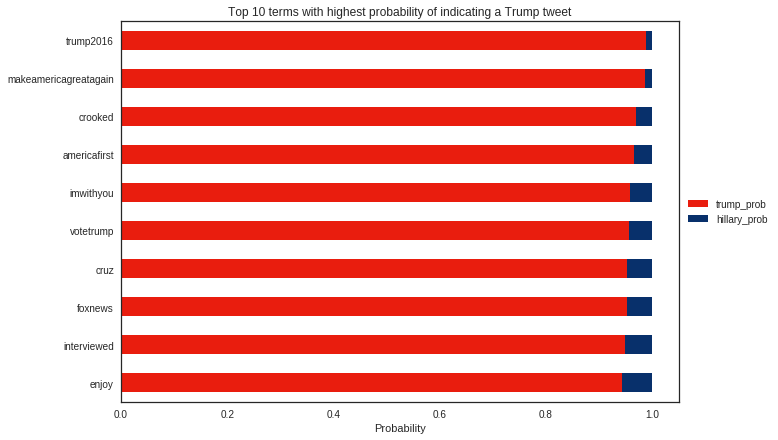

In [34]:
sns.set_context({"figure.figsize": (10, 7)})
top_df_t.plot(kind='barh', stacked=True, color=["#E91D0E","#08306B"]).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yticks(range(len(top_df_t['word'])), list(top_df_t['word']))
plt.title('Top 10 terms with highest probability of indicating a Trump tweet')
plt.xlabel('Probability')

Top 10 terms with highest probability of indicating a *Hillary* tweet
-------------------------------------------------------------------

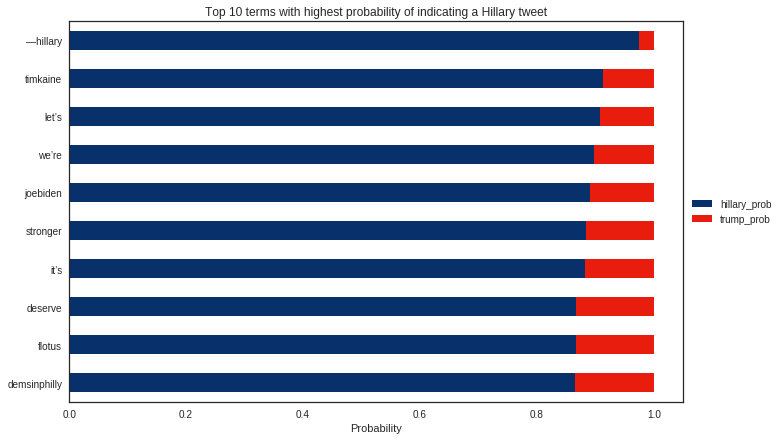

In [35]:
sns.set_context({"figure.figsize": (11, 7)})
top_df_h.plot(kind='barh', stacked=True, color=["#08306B","#E91D0E"]).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yticks(range(len(top_df_h['word'])), list(top_df_h['word']))
plt.title('Top 10 terms with highest probability of indicating a Hillary tweet')
plt.xlabel('Probability')

----------

4. Testing it out
=================

***Just gonna make up some tweets real quick...***

In [36]:
my_1st_tweet = 'America needs a leader who treats women with respect'
my_2nd_tweet = 'My hands are so yuge, just ask @seanhannity'

In [37]:
print("Tweet #1:", "'",my_1st_tweet, "'", ' \n \n', "I'm about %.0f%%" % (100 * max(nb_detector.predict_proba([my_1st_tweet])[0])), "sure this was tweeted by", nb_detector.predict([my_1st_tweet])[0])

Tweet #1: ' America needs a leader who treats women with respect '  
 
 I'm about 83% sure this was tweeted by Hillary


In [38]:
print("Tweet #2:", "'",my_2nd_tweet, "'", ' \n \n', "I'm about %.0f%%" % (100 * max(nb_detector.predict_proba([my_2nd_tweet])[0])), "sure this was tweeted by", nb_detector.predict([my_2nd_tweet])[0])

Tweet #2: ' My hands are so yuge, just ask @seanhannity '  
 
 I'm about 71% sure this was tweeted by Trump


----------

5. Enter your tweet!
====================

 1. Write your tweet in the cell below
 2. Run the cell (or the notebook, if you haven't yet)
 3. Check out the results!

In [39]:
your_tweet = 'ENTER YOUR TWEET HERE, INSIDE THE QUOTES'


# ---- this part stays the same----
if your_tweet == 'ENTER YOUR TWEET HERE, INSIDE THE QUOTES':
    pass
else:
    print("Tweet #1:", "'",your_tweet, "'", ' \n \n', "I'm about %.0f%%" % (100 * max(nb_detector.predict_proba([your_tweet])[0])), "sure this was tweeted by", nb_detector.predict([your_tweet])[0])